In [48]:
import glob
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import box

from sklearn.metrics import classification_report

### Functions to group predictions and ground truth annotations (if same specie and overlapping times)

In [49]:
def get_gt_classification(gt_classification, bird=False):
    
    if bird:
        # From classification make Alaudidae, Fringilla, Lanius class Bird
        gt_classification["specie"] = gt_classification["specie"].replace("Alaudidae", "Bird")
        gt_classification["specie"] = gt_classification["specie"].replace("Fringilla", "Bird")
        gt_classification["specie"] = gt_classification["specie"].replace("Lanius", "Bird")
    else:
        # From classification remove Bird, Alaudidae, Fringilla, Lanius
        gt_classification = gt_classification[gt_classification["specie"] != "Bird"]
        gt_classification = gt_classification[gt_classification["specie"] != "Alaudidae"]
        gt_classification = gt_classification[gt_classification["specie"] != "Fringilla"]
        gt_classification = gt_classification[gt_classification["specie"] != "Lanius"]

    # Make Sturnus unicolor, Sturnus
    gt_classification["specie"] = gt_classification["specie"].replace("Sturnus unicolor", "Sturnus")

    # Make Curruca melanocephala and Curruca undata, Sylvia
    gt_classification["specie"] = gt_classification["specie"].replace("Curruca melanocephala", "Sylvia")
    gt_classification["specie"] = gt_classification["specie"].replace("Curruca undata", "Sylvia")
    # Make Curruca, Sylvia
    gt_classification["specie"] = gt_classification["specie"].replace("Curruca", "Sylvia")

    # Linaria Cannabina, Linaria cannabina
    gt_classification["specie"] = gt_classification["specie"].replace("Linaria Cannabina", "Linaria cannabina")
    # Galerida Cristata, Galerida cristata
    gt_classification["specie"] = gt_classification["specie"].replace("Galerida Cristata", "Galerida cristata")

    # No audio, Background
    gt_classification["specie"] = gt_classification["specie"].replace("No audio", "Background")    

    return gt_classification

def group_consecutive_predictions_birdnet(predictions_df):
    grouped_predictions = []
    current_group = []
    last_end = None
    predictions_df.sort_values(by=['Start (s)', 'End (s)', 'Confidence'], ascending=[True, True, False], inplace=True)
    predictions_df.drop_duplicates(subset=['Start (s)', 'End (s)'], keep='first', inplace=True)
    predictions_df.reset_index(drop=True, inplace=True)
    for _, row in predictions_df.iterrows():
        if current_group and (row['Start (s)'] != last_end or row['Scientific name'] != current_group[-1]['Scientific name']):
            # New group starts here
            grouped_predictions.append(current_group)
            current_group = []
        current_group.append(row)
        last_end = row['End (s)']
    if current_group:  # Add last group
        grouped_predictions.append(current_group)
    # Combine groups in unique predictions
    combined_predictions = []
    for group in grouped_predictions:
        combined_prediction = {
            'Start (s)': group[0]['Start (s)'],
            'End (s)': group[-1]['End (s)'],
            'Scientific name': group[0]['Scientific name'],
            'Confidence': max(item['Confidence'] for item in group)  # conf = max confidence in group
        }
        combined_predictions.append(combined_prediction)

    return combined_predictions

def group_consecutive_annotations_gt(annotations_df):
    annotations_df.sort_values(by=['path', 'specie', 'start_time'], inplace=True)
    grouped_predictions = []
    current_group = []
    last_end = None
    last_path = None
    last_specie = None

    for _, row in annotations_df.iterrows():
        if current_group and (row['path'] != last_path or row['specie'] != last_specie or row['start_time'] - last_end >= 2):
            # New group starts here
            grouped_predictions.append(current_group)
            current_group = []
        current_group.append(row)
        last_end = row['end_time']
        last_path = row['path']
        last_specie = row['specie']
    if current_group:  # Add last group
        grouped_predictions.append(current_group)

    # Combine groups into unique predictions
    combined_annotations = []
    for group in grouped_predictions:
        combined_prediction = {
            'path': group[0]['path'],
            'start_time': group[0]['start_time'],
            'end_time': group[-1]['end_time'],
            'specie': group[0]['specie'],
        }
        combined_annotations.append(combined_prediction)

    # data frame
    combined_annotations = pd.DataFrame(combined_annotations)
    
    return combined_annotations

In [50]:
# gt_df = group_consecutive_annotations_gt(gt_df)
# gt_df = pd.DataFrame(gt_df)  # Convert list dict to DataFrame
# print("Número de Ground Truths agrupados: ", len(gt_df))

### Auxiliar Functions

In [51]:
# Function to calculate the IoU
def calculate_iou(interval1, interval2):
    start_max = max(interval1[0], interval2[0])
    end_min = min(interval1[1], interval2[1])
    intersection = max(0, end_min - start_max)
    union = (interval1[1] - interval1[0]) + (interval2[1] - interval2[0]) - intersection
    return intersection / union if union != 0 else 0

def calculate_iou(gt_start, gt_end, det_start, det_end):
    gt_box = box(gt_start, 0, gt_end, 1)
    det_box = box(det_start, 0, det_end, 1)
    intersection = gt_box.intersection(det_box).length
    union = gt_box.union(det_box).length
    return intersection / union if union > 0 else 0

In [52]:
def is_detection_birdnet(gt_row, grouped_predictions, confidence_threshold, iou_threshold=0):
    for prediction in grouped_predictions:
        if prediction['Confidence'] >= confidence_threshold:
            iou = calculate_iou((prediction['Start (s)'], prediction['End (s)']), (gt_row['start_time'], gt_row['end_time']))
            if iou >= iou_threshold:
                return True
    return False

def is_detection_classification_birdnet(gt_row, predictions_df, confidence_threshold=0, iou_threshold=0):
    for _, prediction in predictions_df.iterrows():
        if float(prediction['Confidence']) >= confidence_threshold:
            iou = calculate_iou((prediction['Start (s)'], prediction['End (s)']), (gt_row['start_time'], gt_row['end_time']))
            if (prediction['Scientific name'].lower() == gt_row['specie'].lower() and
                iou >= iou_threshold):
                return True, prediction
    return False, None

In [53]:
# Función para transformar los nombres de las especies
def transform_species_name(specie):
    if specie == "Bird":
        return specie
    elif specie == "No audio":
        return "No Bird"
    # Si Galerida cristata, se transforma a Galerida Cristata
    elif specie == "Galerida Cristata":
        return "Galerida cristata"
    # Si Linnaria cannabina, se transforma a Linaria Cannabina
    elif specie == "Linaria Cannabina":
        return "Linaria cannabina"
    elif specie == "Sylvia" or specie == "Curruca" or specie == "Sylviidae":
        return "Sylviidae"
    elif specie == "Background":
        return "Background"
    elif specie == "Other":
        return "Other"
    elif specie == "Alaudidae":
        return "Alaudidae"
    elif specie == "Fringilla":
        return "Fringillidae"
    elif len(specie.split()) == 2:
        return specie  # Se manejará la cursiva en el gráfico
    else:
        return f"{specie} sp."  # Se manejará la cursiva en el gráfico

In [54]:
def parse_segment_filename(filename):
    parts = filename.split("_")
    original_path = "_".join(parts[:-3]) + ".WAV"
    start_time = float(parts[-3])
    end_time = float(parts[-2])
    return original_path, start_time, end_time

In [59]:
def classifier_performance(gt_csv = "../Data/Dataset/CSVs/test_with_augmented_bg.csv", predictions_folder_name = "2025_CustomClassifier_DF_REPEAT_025_MIXUP_SEGMENTS", iou_threshold = 0.1):
    # Load data
    # PATH = "../BirdNET/"
    # gt_csv = PATH + "Dataset/correct_predict_test_model12_conf015.csv"

    gt_df = pd.read_csv(gt_csv)
    gt_df = get_gt_classification(gt_df, bird=True)

    # If class is curruca or sylvia set it as Sylviidae
    gt_df.loc[gt_df['specie'] == 'Sylvia', 'specie'] = 'Sylviidae'
    gt_df = group_consecutive_annotations_gt(gt_df)

    unique_species = gt_df['specie'].unique().tolist() # + ['Background']

    # make Bird the first element and Background the last one
    unique_species.remove('Bird')
    unique_species.remove('Background')
    unique_species = ['Bird'] + unique_species + ['Background']

    conf_matrix = pd.DataFrame(np.zeros((len(unique_species), len(unique_species)), dtype=int), index=unique_species, columns=unique_species)

    metrics = ['Number of Predictions', 'TP', 'FP', 'FN', 'TN', 'TPD', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Idx Pred/Ann', 'Maximum Likelihood']
    metrics_values = {metric: 0 for metric in metrics}

    # calculate number of predictions
    predictions_folder = pred_file_path = f"../BirdNET/Predictions/{predictions_folder_name}/"
    # check all files in the folder and subfolder
    for root, _, files in os.walk(predictions_folder):
        for file in files:
            if file.endswith(".csv"):
                predictions_df = pd.read_csv(os.path.join(root, file))
                if len(predictions_df) > 0:
                    grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)
                    metrics_values['Number of Predictions'] += len(grouped_predictions)

    # Process each prediction file
    for _, gt_row in gt_df.iterrows():
        true_species = gt_row['specie']

        predicted_species = "Background"

        gt_start, gt_end = gt_row['start_time'], gt_row['end_time']

        pred_file_path = f"../BirdNET/Predictions/{predictions_folder_name}/{gt_row['path'].split('.')[0]}.BirdNET.results.csv"
        if os.path.exists(pred_file_path):
            predictions_df = pd.read_csv(pred_file_path)

            best_match = None
            best_iou = 0

            if len(predictions_df) > 0:
                grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)

                if len(grouped_predictions) > 0:
                    for prediction in grouped_predictions:
                        pred_start = prediction['Start (s)']
                        pred_end = prediction['End (s)']
                        iou = calculate_iou(gt_start, gt_end, pred_start, pred_end)
                        if iou > best_iou:
                            best_iou = iou
                            best_match = prediction
            
            if best_match and best_iou > iou_threshold:
                predicted_species = best_match['Scientific name']

            if predicted_species == "Sylvia":
                predicted_species = "Sylviidae"

        conf_matrix.at[true_species, predicted_species] += 1

        if true_species == 'Bird' and predicted_species != 'Background':
            metrics_values['TPD'] += 1
        elif predicted_species == true_species and true_species != 'Background':
            metrics_values['TP'] += 1
            # print(f"TP: {true_species} {predicted_species}")
        elif predicted_species == 'Background' and true_species != 'Background':
            metrics_values['FN'] += 1
            # print(f"FN: {true_species} {predicted_species}")
        elif (predicted_species != 'Background' and true_species == 'Background') or (predicted_species != true_species and true_species != 'Background'):
            metrics_values['FP'] += 1 
            # print(f"FP: {true_species} {predicted_species}")
        elif predicted_species == 'Background' and true_species == 'Background':
            metrics_values['TN'] += 1
            # print(f"TN: {true_species} {predicted_species}")
        else:
            print(f"Error: {predicted_species} {true_species}")

    # Normalize by row
    conf_matrix_norm = conf_matrix.div(conf_matrix.sum(axis=1), axis=0).fillna(0)

    # Apply transformation to confusion matrix labels
    transformed_index = [transform_species_name(spec) for spec in conf_matrix_norm.index]
    transformed_columns = [transform_species_name(spec) for spec in conf_matrix_norm.columns]

    # Create the plot
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap="Blues", xticklabels=transformed_columns, yticklabels=transformed_index, cbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Ground Truths')
    plt.xlabel('Predictions')

    # Customize labels for italic formatting
    ax = plt.gca()
    xticklabels = []
    yticklabels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        if text != "Bird" and text != "No Bird" and text != "Other" and text != "Background" and text != "Sylviidae" and text != "Fringillidae" and text != "Alaudidae":
            if " sp." in text:
                name_part = text.replace(' sp.', '')  # Species name
                text = rf"$\mathit{{{name_part}}}$ sp."  # Italic species name, non-italic "sp."
            else:
                text = text.replace(' ', r'\ ')
                text = rf"$\mathit{{{text}}}$"  # Italic species name
        xticklabels.append(text)
    ax.set_xticklabels(xticklabels, rotation=90)

    for label in ax.get_yticklabels():
        text = label.get_text()
        if text != "Bird" and text != "No Bird" and text != "Other" and text != "Background" and text != "Sylviidae" and text != "Fringillidae" and text != "Alaudidae":
            if " sp." in text:
                name_part = text.replace(' sp.', '')  # Species name
                text = rf"$\mathit{{{name_part}}}$ sp."  # Italic species name, non-italic "sp."
            else:
                text = text.replace(' ', r'\ ')
                text = rf"$\mathit{{{text}}}$"  # Italic species name
        yticklabels.append(text)
    ax.set_yticklabels(yticklabels, rotation=0)

    plt.tight_layout()

    # save as pdf in the max resolution
    plt.savefig('confusion_matrix_species.pdf', dpi=300, bbox_inches='tight')

    # plt.show()

    # Non normalized confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=transformed_columns, yticklabels=transformed_index, cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('Ground Truths')
    plt.xlabel('Predictions')
    plt.show()

    # metrics_values['FN'] = len(gt_df) - metrics_values['TP']
    metrics_values['Accuracy'] = metrics_values['TP'] / metrics_values['Number of Predictions']
    metrics_values['Precision'] = metrics_values['TP'] / (metrics_values['TP'] + metrics_values['FP'])
    metrics_values['Recall'] = metrics_values['TP'] / (metrics_values['TP'] + metrics_values['FN'])
    metrics_values['F1 Score'] = 2 * metrics_values['Precision'] * metrics_values['Recall'] / (metrics_values['Precision'] + metrics_values['Recall'])
    metrics_values['Idx Pred/Ann'] = metrics_values['Number of Predictions'] / len(gt_df["specie"] != 'Background')
    metrics_values['Maximum Likelihood'] = metrics_values['TP'] / len(gt_df[gt_df['specie'] != 'Background'])

    print("Number of GT: ", len(gt_df))
    for metric, value in metrics_values.items():
        print(f"{metric}: {value}")

    # Get true and predicted labels
    y_true = []
    y_pred = []

    for true_species in unique_species:
        for predicted_species in unique_species:
            count = conf_matrix.at[true_species, predicted_species]
            y_true.extend([true_species] * count)
            y_pred.extend([predicted_species] * count)

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=unique_species, zero_division=0)
    print("\nClassification Report:\n")
    print(report)


In [56]:
def detector_and_classifier_performance(gt_csv = "../Data/Dataset/CSVs/test_with_augmented_bg.csv", predictions_folder_name = "BirdSongDetector_and_2025_CustomClassifier_DF_REPEAT_025_MIXUP_SEGMENTS", iou_threshold = 0.1):
    gt_df = pd.read_csv(gt_csv)
    gt_df = get_gt_classification(gt_df, bird=True)

    # If class is curruca or sylvia set it as Sylviidae
    gt_df.loc[gt_df['specie'] == 'Sylvia', 'specie'] = 'Sylviidae'
    gt_df = group_consecutive_annotations_gt(gt_df)

    unique_species = gt_df['specie'].unique().tolist() # + ['Background']

    # make Bird the first element and Background the last one
    unique_species.remove('Bird')
    unique_species.remove('Background')
    unique_species = ['Bird'] + unique_species + ['Background']

    conf_matrix = pd.DataFrame(np.zeros((len(unique_species), len(unique_species)), dtype=int), index=unique_species, columns=unique_species)

    metrics = ['Number of Predictions', 'TP', 'FP', 'FN', 'TN', 'TPD', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Idx Pred/Ann', 'Maximum Likelihood']
    metrics_values = {metric: 0 for metric in metrics}

    # Load predictions
    predictions_folder = f"../BirdNET/Predictions/{predictions_folder_name}/"
    prediction_files = [f for f in os.listdir(predictions_folder) if f.endswith(".csv")]

    for file in prediction_files:
        if file.endswith(".csv"):
            predictions_df = pd.read_csv(os.path.join(predictions_folder, file))
            if len(predictions_df) > 0:
                grouped_predictions = group_consecutive_predictions_birdnet(predictions_df)
                metrics_values['Number of Predictions'] += len(grouped_predictions)

    for _, gt_row in gt_df.iterrows():
        true_species = gt_row['specie']

        predicted_species = "Background"

        gt_file = gt_row['path'].split("/")[-1]
        gt_start, gt_end = float(gt_row['start_time']), float(gt_row['end_time'])

        best_match = None
        best_iou = 0
        is_detected = False
        # best_pred_path = None
        
        for pred_file in prediction_files:
            pred_path, det_start, det_end = parse_segment_filename(pred_file.replace(".csv", ""))
            # print(pred_path, gt_file)
            if pred_path == gt_file:
                iou = calculate_iou(gt_start, gt_end, det_start, det_end)  
                if iou > best_iou:
                    best_iou = iou
                    # best_pred_path = pred_file
                    # read the prediction file
                    pred_df = pd.read_csv(os.path.join(predictions_folder, pred_file))
                    grouped_predictions = group_consecutive_predictions_birdnet(pred_df)
                    
                    if len(grouped_predictions) > 0:
                        # best prediction is the one with the highest confidence score
                        best_match = max(grouped_predictions, key=lambda x: x['Confidence'])
                        iou = calculate_iou(gt_start, gt_end, best_match["Start (s)"] + det_start, best_match["End (s)"] + det_start)

                        if iou > best_iou:
                            best_iou = iou

                    if iou > iou_threshold:
                        is_detected = True  

        if best_match and best_iou > iou_threshold:
            predicted_species = best_match['Scientific name']

        if predicted_species == "Sylvia":
                predicted_species = "Sylviidae"
        
        # print(f"GT: {true_species}, Pred: {predicted_species}, path: {gt_file}, gt_start: {gt_start}, gt_end: {gt_end}, det_start: {det_start}, det_end: {det_end}, iou: {best_iou}")
        
        # if true_species == "Bird" and predicted_species != "Background":
        #     predicted_species = "Bird"
        if predicted_species == "Background" and is_detected:
            # print(f"Bird Song detected: {gt_file}, {gt_start}, {gt_end}, {true_species}, {predicted_species}, {best_match}")
            predicted_species = "Bird"

        conf_matrix.at[true_species, predicted_species] += 1
        # print(f"path: {gt_file}, pred_path: {best_pred_path}, GT: {true_species}, Pred: {predicted_species}, gt_start: {gt_start}, gt_end: {gt_end}, best_match: {best_match}")

        if true_species == 'Bird' and predicted_species != 'Background':
            metrics_values['TPD'] += 1
        elif predicted_species == true_species and true_species != 'Background':
            metrics_values['TP'] += 1
            # print(f"TP: {true_species} {predicted_species}")
        elif predicted_species == 'Background' and true_species != 'Background':
            metrics_values['FN'] += 1
            # print(f"FN: {true_species} {predicted_species}")
        elif (predicted_species != 'Background' and true_species == 'Background') or (predicted_species != true_species and true_species != 'Background'):
            metrics_values['FP'] += 1 
            # print(f"FP: {true_species} {predicted_species}")
        elif predicted_species == 'Background' and true_species == 'Background':
            metrics_values['TN'] += 1
            # print(f"TN: {true_species} {predicted_species}")
        else:
            print(f"Error: {predicted_species} {true_species}")

    # Normalize by row
    conf_matrix_norm = conf_matrix.div(conf_matrix.sum(axis=1), axis=0).fillna(0)

    # Apply transformation to confusion matrix labels
    transformed_index = [transform_species_name(spec) for spec in conf_matrix_norm.index]
    transformed_columns = [transform_species_name(spec) for spec in conf_matrix_norm.columns]

    # Create the plot
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap="Blues", xticklabels=transformed_columns, yticklabels=transformed_index, cbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Ground Truths')
    plt.xlabel('Predictions')

    # Customize labels for italic formatting
    ax = plt.gca()
    xticklabels = []
    yticklabels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        if text != "Bird" and text != "No Bird" and text != "Other" and text != "Background" and text != "Sylviidae" and text != "Fringillidae" and text != "Alaudidae":
            if " sp." in text:
                name_part = text.replace(' sp.', '')  # Species name
                text = rf"$\mathit{{{name_part}}}$ sp."  # Italic species name, non-italic "sp."
            else:
                text = text.replace(' ', r'\ ')
                text = rf"$\mathit{{{text}}}$"  # Italic species name
        xticklabels.append(text)
    ax.set_xticklabels(xticklabels, rotation=90)

    for label in ax.get_yticklabels():
        text = label.get_text()
        if text != "Bird" and text != "No Bird" and text != "Other" and text != "Background" and text != "Sylviidae" and text != "Fringillidae" and text != "Alaudidae":
            if " sp." in text:
                name_part = text.replace(' sp.', '')  # Species name
                text = rf"$\mathit{{{name_part}}}$ sp."  # Italic species name, non-italic "sp."
            else:
                text = text.replace(' ', r'\ ')
                text = rf"$\mathit{{{text}}}$"  # Italic species name
        yticklabels.append(text)
    ax.set_yticklabels(yticklabels, rotation=0)

    plt.tight_layout()

    # save as pdf in the max resolution
    plt.savefig('confusion_matrix_species.pdf', dpi=300, bbox_inches='tight')

    plt.show()

    # Non normalized confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=transformed_columns, yticklabels=transformed_index, cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('Ground Truths')
    plt.xlabel('Predictions')
    plt.show()

    # Compute and siplay metrics
    metrics_values['Accuracy'] = metrics_values['TP'] / metrics_values['Number of Predictions']
    metrics_values['Precision'] = metrics_values['TP'] / (metrics_values['TP'] + metrics_values['FP'])
    metrics_values['Recall'] = metrics_values['TP'] / (metrics_values['TP'] + metrics_values['FN'])
    metrics_values['F1 Score'] = 2 * metrics_values['Precision'] * metrics_values['Recall'] / (metrics_values['Precision'] + metrics_values['Recall'])
    metrics_values['Idx Pred/Ann'] = metrics_values['Number of Predictions'] / len(gt_df["specie"] != 'Background')
    metrics_values['Maximum Likelihood'] = metrics_values['TP'] / len(gt_df[gt_df['specie'] != 'Background'])

    print("Number of GT: ", len(gt_df))
    for metric, value in metrics_values.items():
        print(f"{metric}: {value}")

    # Get true and predicted labels
    y_true = []
    y_pred = []

    for true_species in unique_species:
        for predicted_species in unique_species:
            count = conf_matrix.at[true_species, predicted_species]
            y_true.extend([true_species] * count)
            y_pred.extend([predicted_species] * count)

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=unique_species, zero_division=0)
    print("\nClassification Report:\n")
    print(report)


## Fine Tuned BirdNET Classifier

Fine Tuned BirdNET


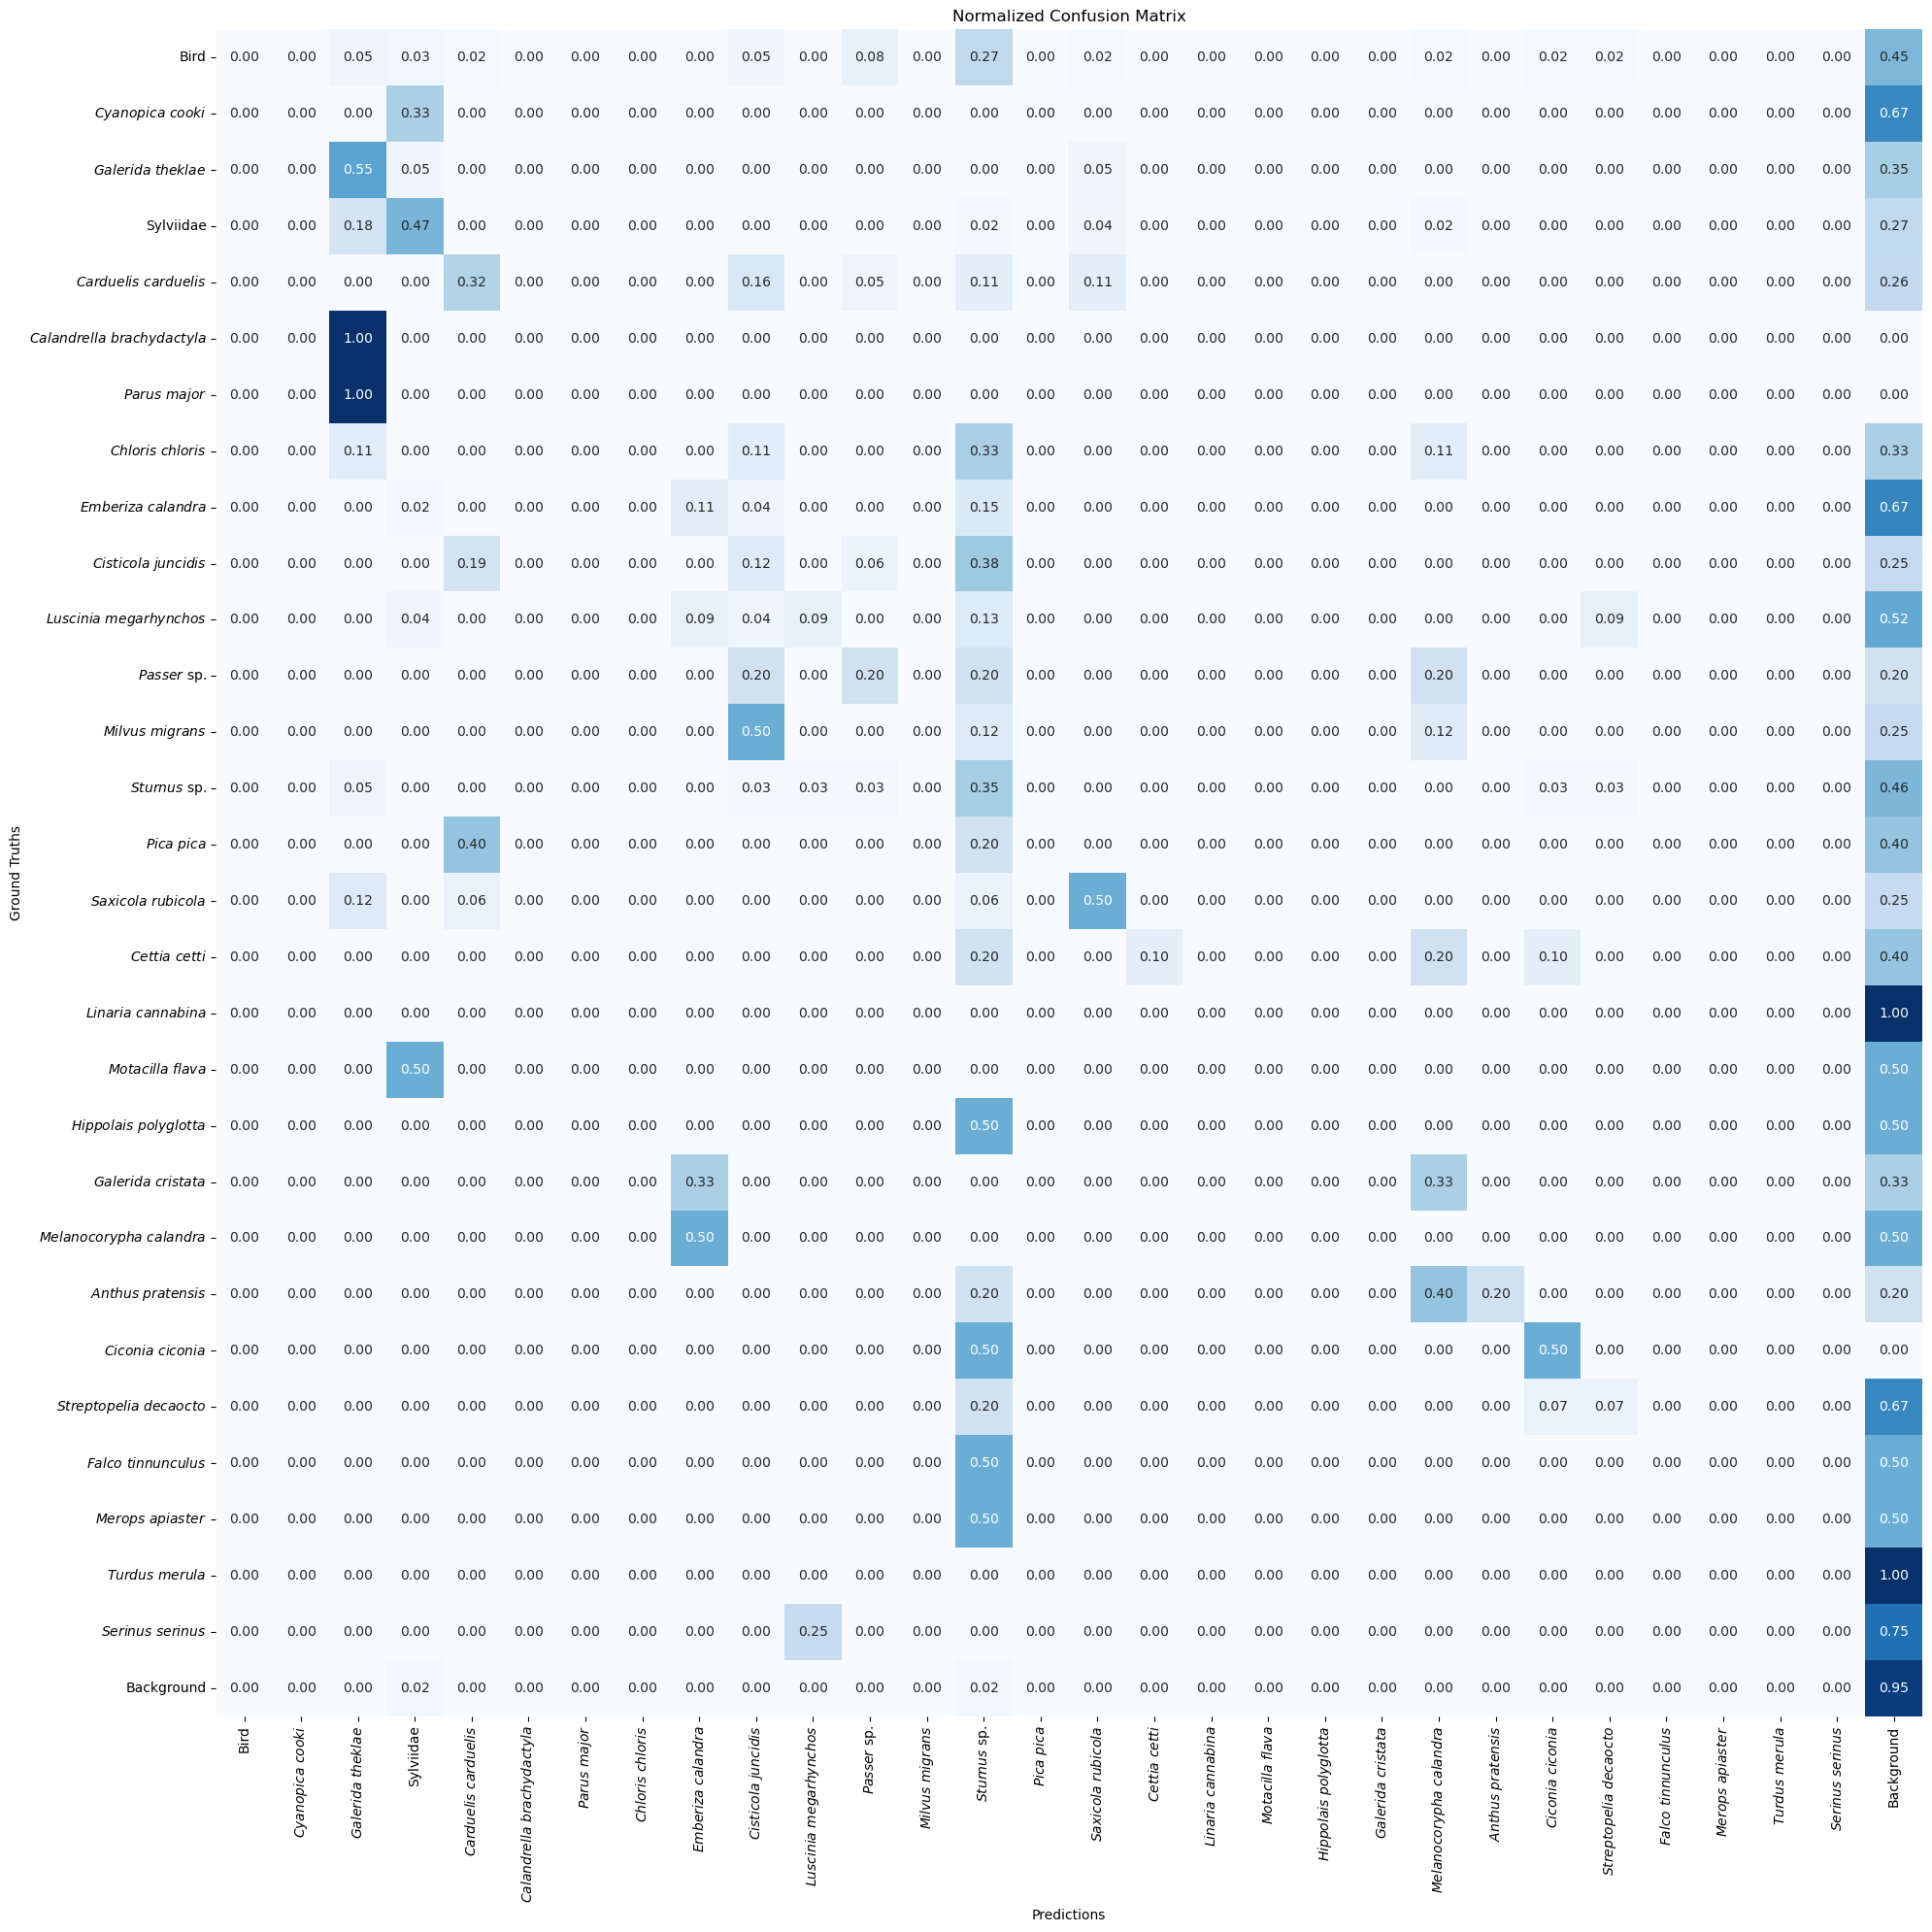

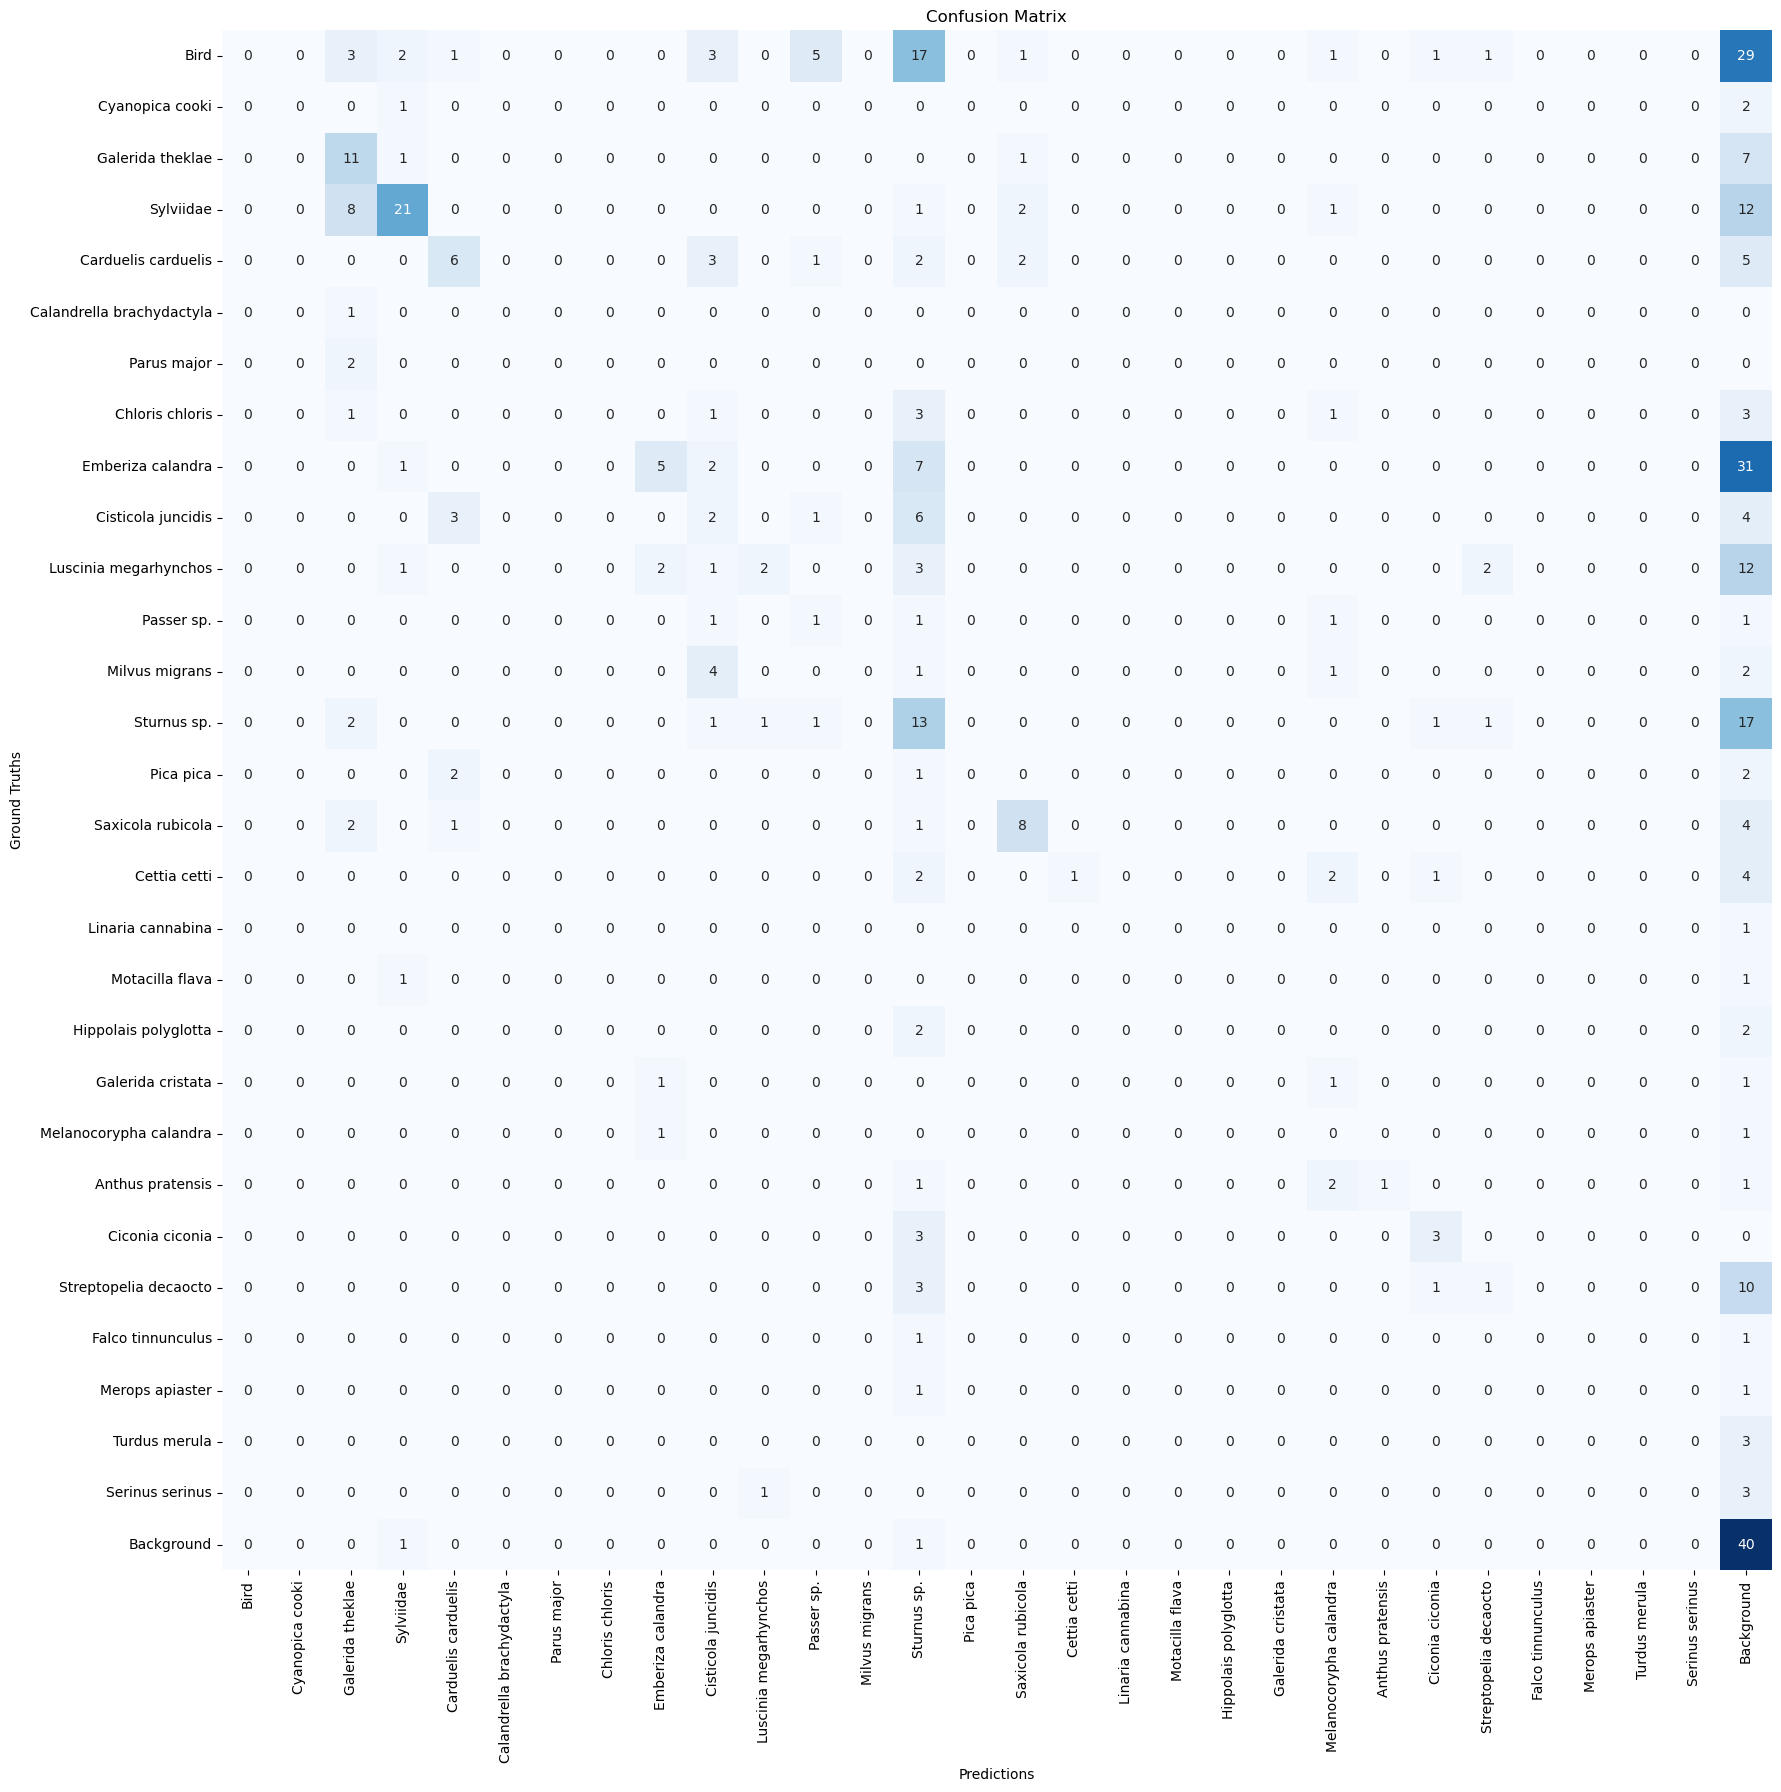

Number of GT:  420
Number of Predictions: 343
TP: 75
FP: 110
FN: 160
TN: 40
TPD: 35
Accuracy: 0.21865889212827988
Precision: 0.40540540540540543
Recall: 0.3191489361702128
F1 Score: 0.35714285714285715
Idx Pred/Ann: 0.8166666666666667
Maximum Likelihood: 0.1984126984126984

Classification Report:

                           precision    recall  f1-score   support

                     Bird       1.00      0.20      0.33         5
          Cyanopica cooki       0.20      0.95      0.33        42
         Galerida theklae       0.00      0.00      0.00        64
                Sylviidae       0.00      0.00      0.00         1
      Carduelis carduelis       0.46      0.32      0.37        19
Calandrella brachydactyla       1.00      0.10      0.18        10
              Parus major       0.00      0.00      0.00         9
          Chloris chloris       0.43      0.50      0.46         6
        Emberiza calandra       0.11      0.12      0.12        16
       Cisticola juncidis     

In [60]:
print("Fine Tuned BirdNET")
classifier_performance(gt_csv = "../Data/Dataset/CSVs/test_with_augmented_bg.csv", 
                    predictions_folder_name = "2025_CustomClassifier_DF_REPEAT_025_MIXUP_SEGMENTS", 
                    iou_threshold = 0.2)

## Bird Song Detector + BirdNET

Bird Song Detector + Fine Tuned BirdNET


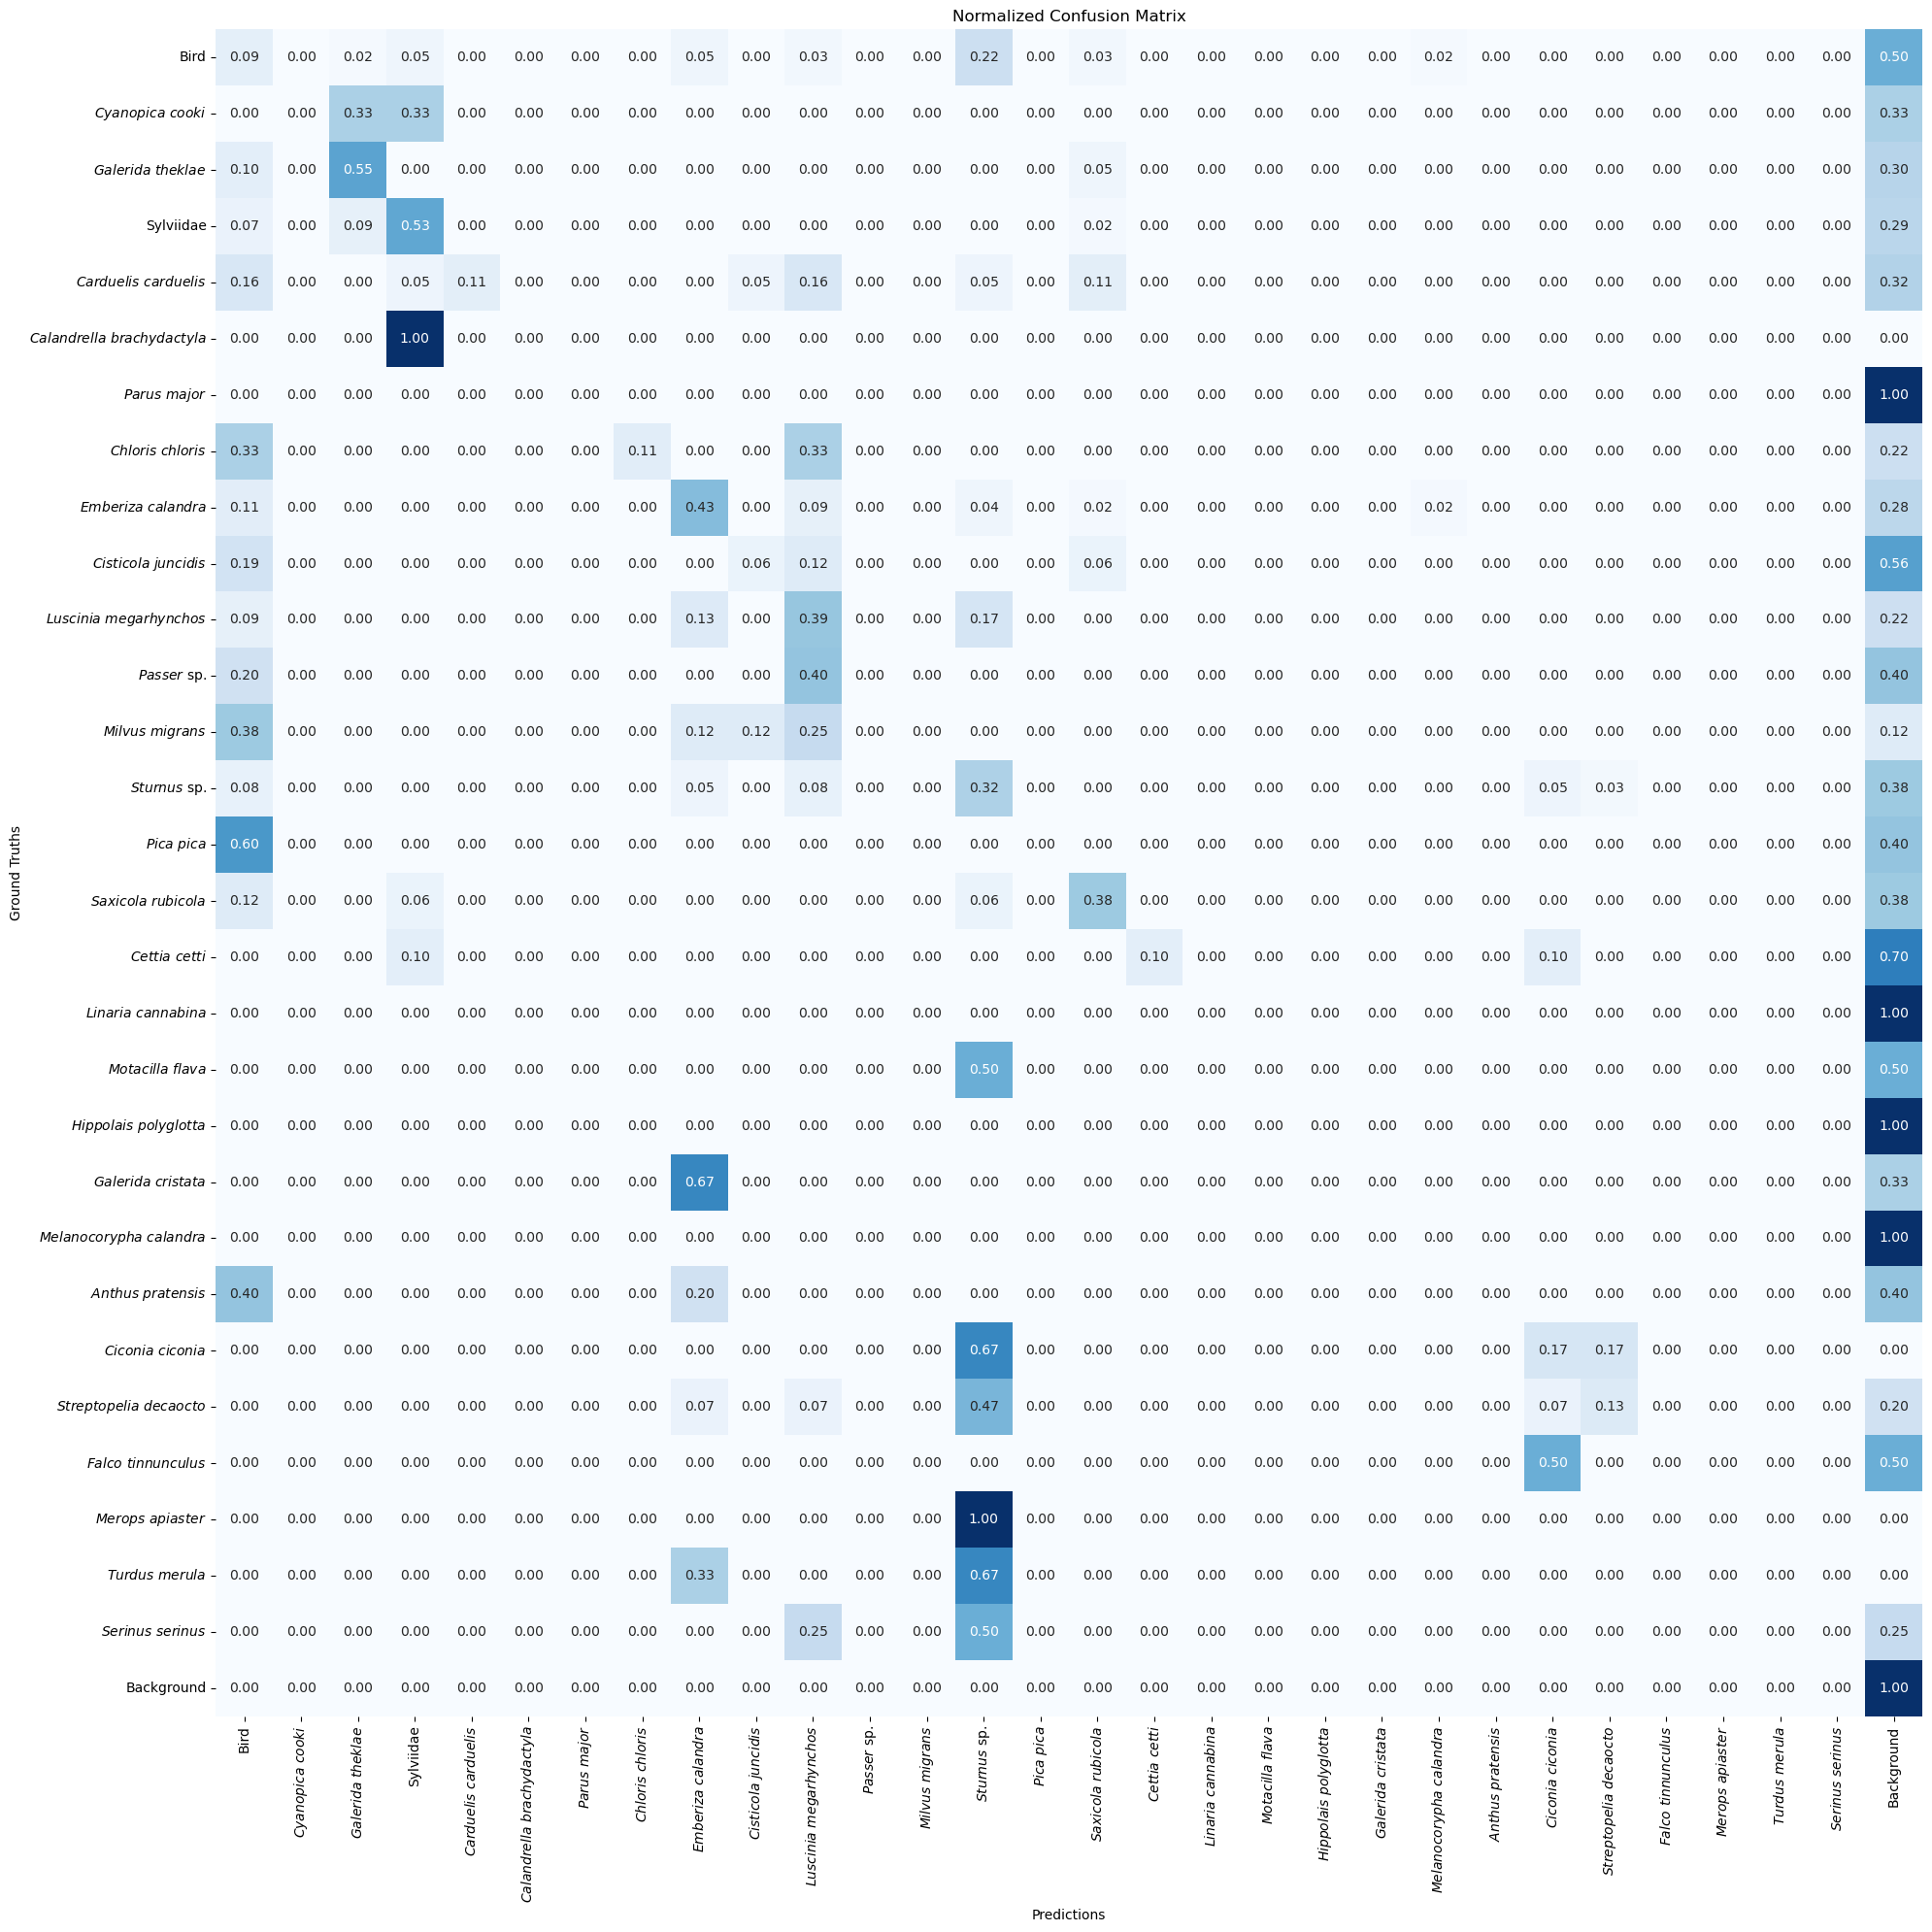

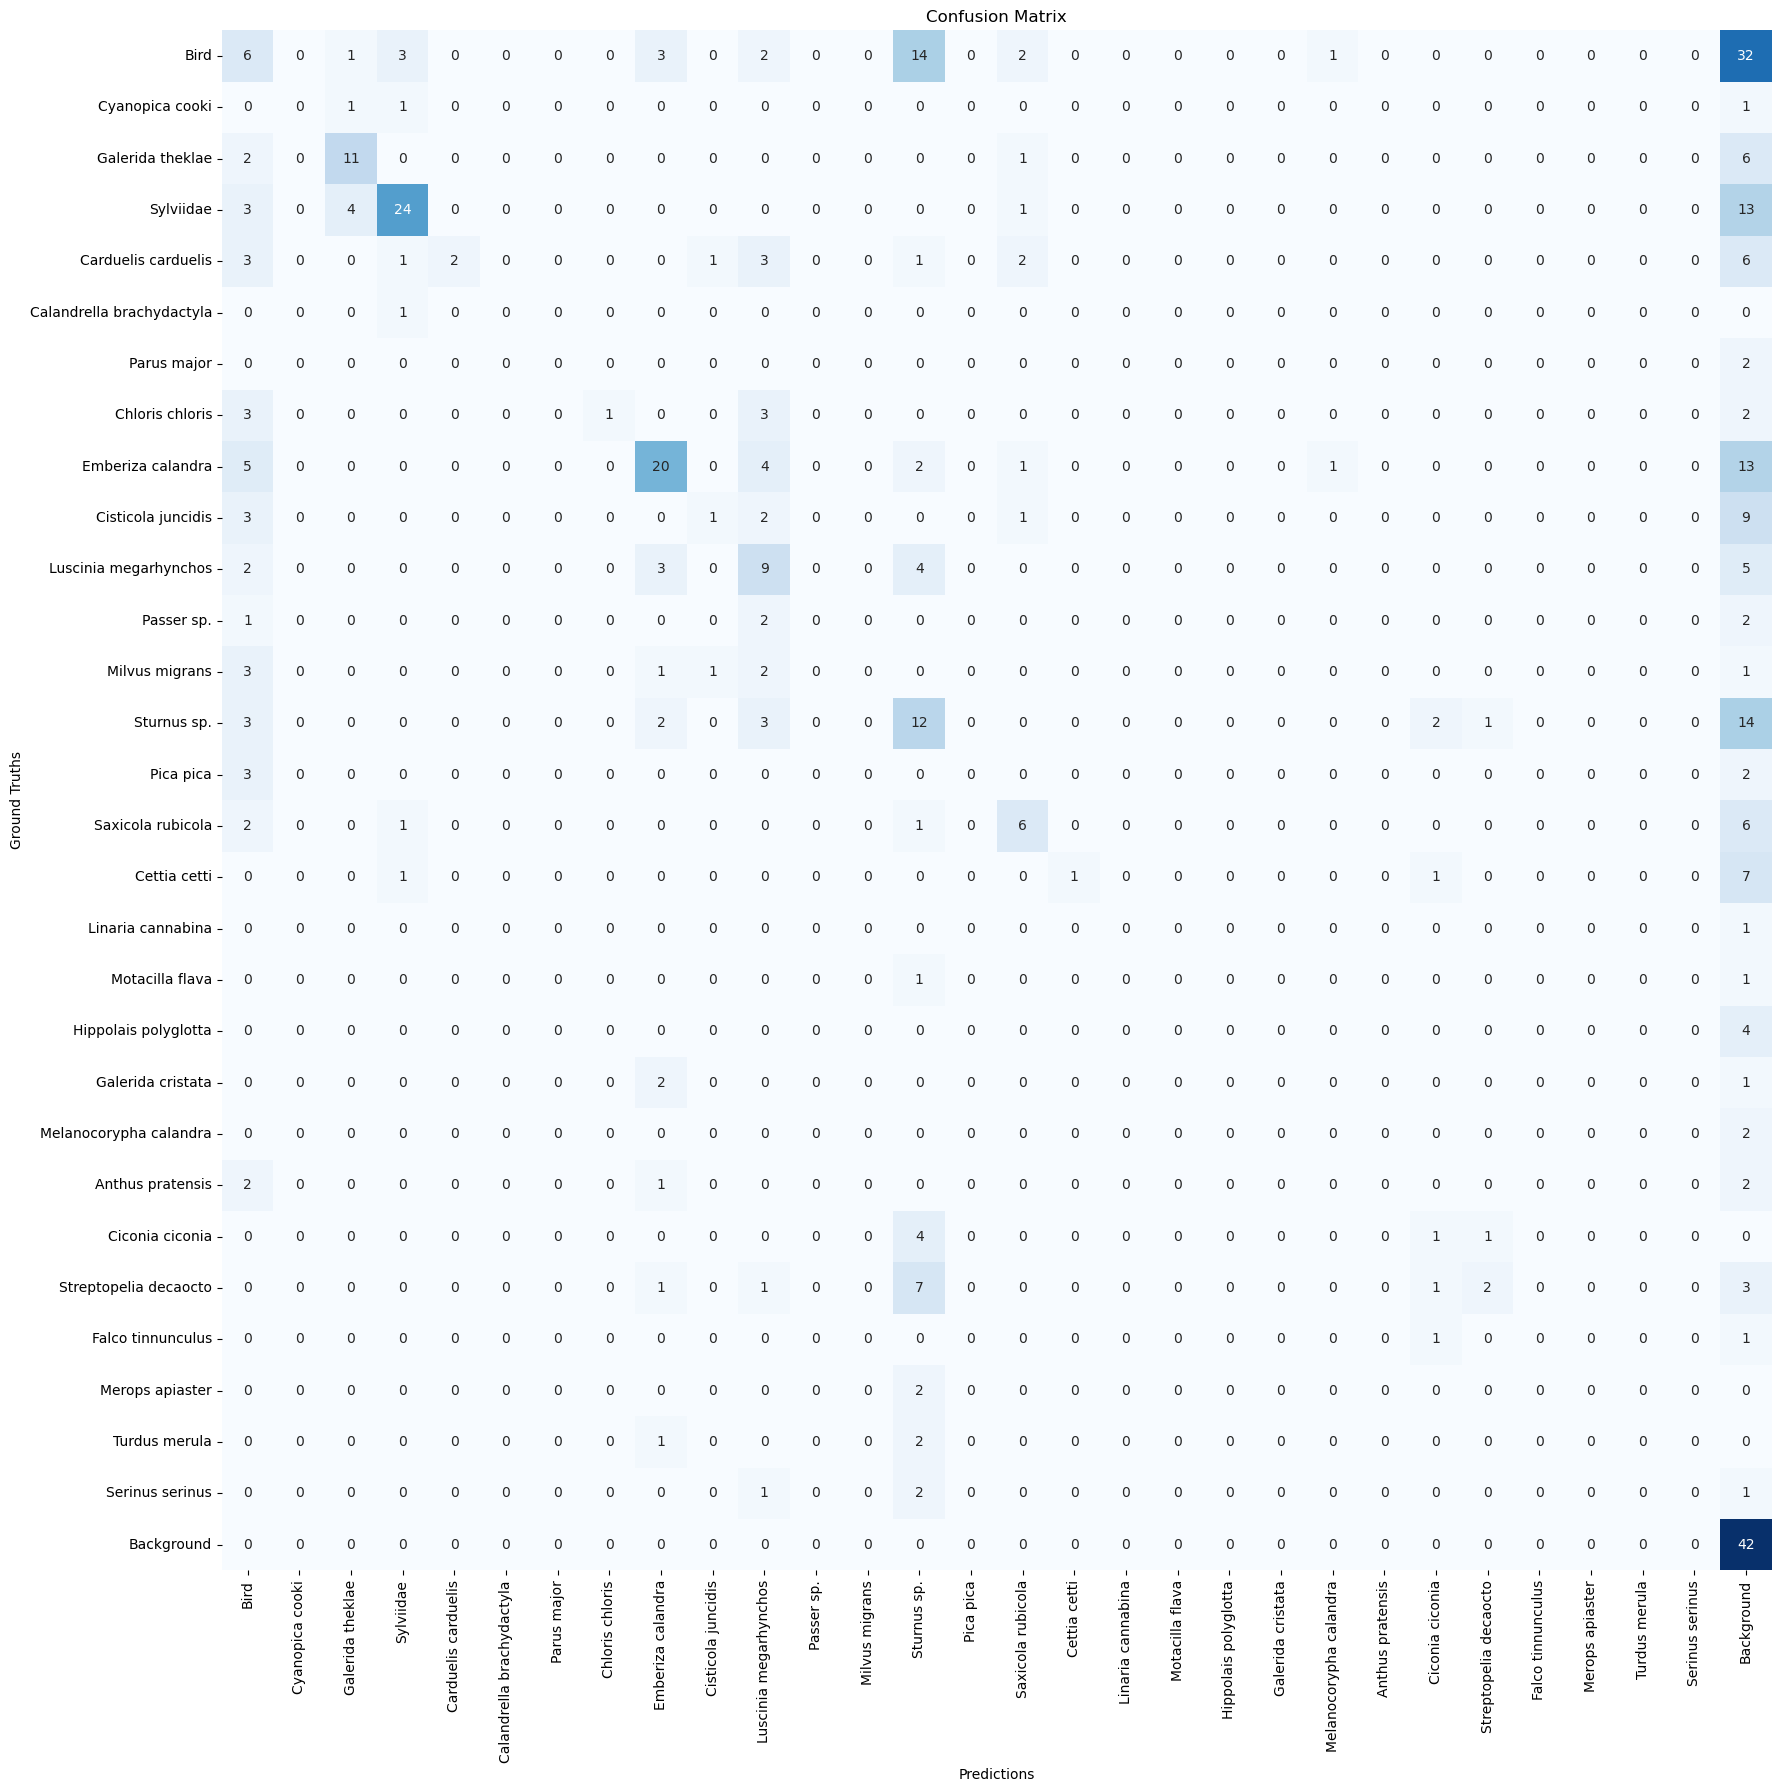

Number of GT:  420
Number of Predictions: 224
TP: 90
FP: 119
FN: 137
TN: 42
TPD: 32
Accuracy: 0.4017857142857143
Precision: 0.430622009569378
Recall: 0.3964757709251101
F1 Score: 0.4128440366972477
Idx Pred/Ann: 0.5333333333333333
Maximum Likelihood: 0.23809523809523808

Classification Report:

                           precision    recall  f1-score   support

                     Bird       0.00      0.00      0.00         5
          Cyanopica cooki       0.23      1.00      0.38        42
         Galerida theklae       0.15      0.09      0.11        64
                Sylviidae       0.00      0.00      0.00         1
      Carduelis carduelis       1.00      0.11      0.19        19
Calandrella brachydactyla       1.00      0.10      0.18        10
              Parus major       1.00      0.11      0.20         9
          Chloris chloris       0.17      0.17      0.17         6
        Emberiza calandra       0.33      0.06      0.11        16
       Cisticola juncidis       0

In [58]:
print("Bird Song Detector + Fine Tuned BirdNET")
detector_and_classifier_performance(gt_csv = "../Data/Dataset/CSVs/test_with_augmented_bg.csv", predictions_folder_name="BirdSongDetector_and_2025_CustomClassifier_DF_REPEAT_025_MIXUP_SEGMENTS", iou_threshold=0.1)

## BirdSongDetector + RandomForest

# Spider Plots

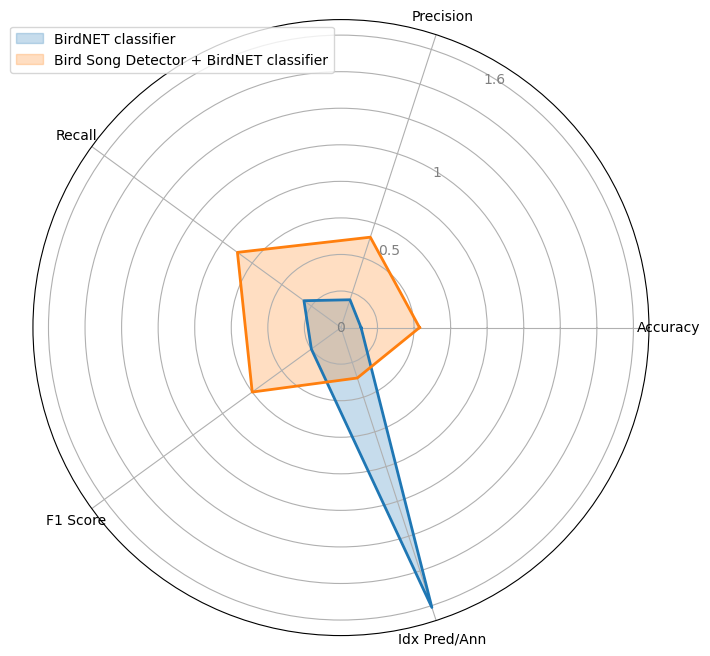

In [15]:
import numpy as np
import matplotlib.pyplot as plt

'''
BirdNET
Número de Anotaciones:  521
Number of predictions: 836
True Positive:  136
False Positive:  700
False Negative:  406
True Negative:  0
Accuracy:  0.10950080515297907
Precision:  0.16267942583732056
Recall:  0.25092250922509224
F1 Score:  0.19738751814223512
Idx Pred/Ann:  1.6046065259117082

Bird Song Detector + BirdNET
Número de Anotaciones:  521
Number of predictions:  151
True Positive:  80
False Positive:  73
False Negative:  35
True Negative:  0
Accuracy:  0.425531914893617
Precision:  0.5228758169934641
Recall:  0.6956521739130435
F1 Score:  0.5970149253731343
Idx Pred/Ann:  0.28982725527831094
'''

# Datos de las métricas para los dos modelos
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Idx Pred/Ann']
model_1 = [0.11, 0.16, 0.25, 0.20, 1.61]
model_2 = [0.43, 0.52, 0.70, 0.60, 0.29]

# Número de variables
num_vars = len(metrics)

# Ángulos para la gráfica de radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Completar el círculo
model_1 += model_1[:1]
model_2 += model_2[:1]
angles += angles[:1]

# Inicializar la figura
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Dibujar la gráfica de radar
ax.fill(angles, model_1, color='C0', alpha=0.25, label='BirdNET classifier')
ax.fill(angles, model_2, color='C1', alpha=0.25, label='Bird Song Detector + BirdNET classifier')

# Dibujar las líneas de los modelos
ax.plot(angles, model_1, color='C0', linewidth=2, linestyle='solid')
ax.plot(angles, model_2, color='C1', linewidth=2, linestyle='solid')

# Añadir las etiquetas de las métricas
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

# Añadir la leyenda
plt.legend(loc='upper right', bbox_to_anchor=(0.5, 1))

# Add min, middle and max value to the radar chart
ax.text(45, 0, '0', color='grey', ha='center', va='center')
ax.text(45, 0.5, '0.5', color='grey', ha='center', va='center')
ax.text(45, 1, '1', color='grey', ha='center', va='center')
ax.text(45, 1.6, '1.6', color='grey', ha='center', va='center')

# Título de la gráfica
# plt.title('Comparison of Model Metrics')

# Mostrar la gráfica
plt.show()

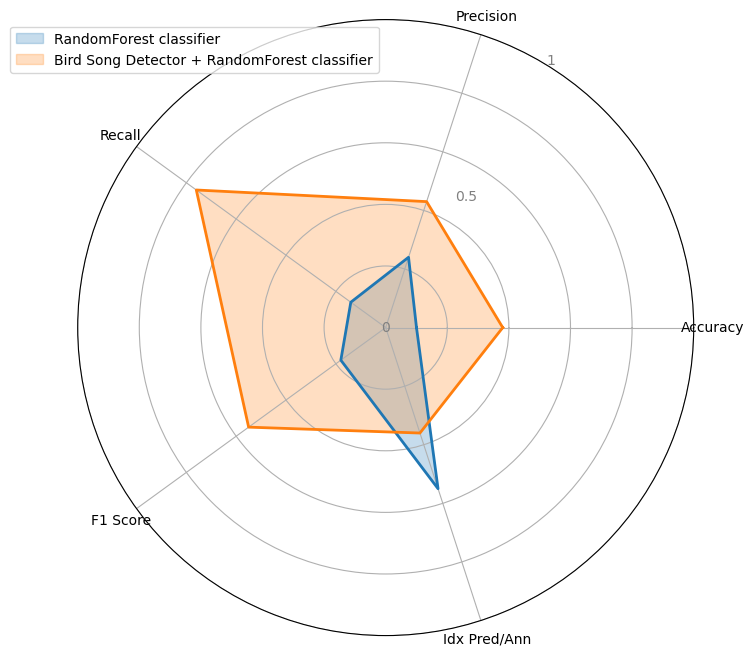

In [19]:
import numpy as np
import matplotlib.pyplot as plt

'''
RandomForest
Número de Anotaciones:  521
Number of predictions: 289
True Positive:  70
False Positive:  219
False Negative:  416
True Negative:  0
Accuracy:  0.09929078014184398
Precision:  0.2422145328719723
Recall:  0.1440329218106996
F1 Score:  0.18064516129032257
Idx Pred/Ann:  0.5547024952015355

Bird Song Detector + RandomForest
Número de Anotaciones:  521
Number of predictions:  188
True Positive:  71
False Positive:  94
False Negative:  23
True Negative:  0
Accuracy:  0.3776595744680851
Precision:  0.4303030303030303
Recall:  0.7553191489361702
F1 Score:  0.5482625482625483
Idx Pred/Ann:  0.36084452975047987
'''

# Datos de las métricas para los dos modelos
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Idx Pred/Ann']
model_1 = [0.10, 0.24, 0.14, 0.18, 0.55]
model_2 = [0.38, 0.43, 0.76, 0.55, 0.36]

# Número de variables
num_vars = len(metrics)

# Ángulos para la gráfica de radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Completar el círculo
model_1 += model_1[:1]
model_2 += model_2[:1]
angles += angles[:1]

# Inicializar la figura
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Dibujar la gráfica de radar
ax.fill(angles, model_1, color='C0', alpha=0.25, label='RandomForest classifier')
ax.fill(angles, model_2, color='C1', alpha=0.25, label='Bird Song Detector + RandomForest classifier')

# Dibujar las líneas de los modelos
ax.plot(angles, model_1, color='C0', linewidth=2, linestyle='solid')
ax.plot(angles, model_2, color='C1', linewidth=2, linestyle='solid')

# Añadir las etiquetas de las métricas
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

# Añadir la leyenda
plt.legend(loc='upper right', bbox_to_anchor=(0.5, 1))

# Add min, middle and max value to the radar chart
ax.set_ylim(0, 1)
ax.text(45, 0, '0', color='grey', ha='center', va='center')
ax.text(45, 0.5, '0.5', color='grey', ha='center', va='center')
ax.text(45, 1+0.02, '1', color='grey', ha='center', va='center')

# Título de la gráfica
# plt.title('Comparison of Model Metrics')

# Mostrar la gráfica
plt.show()

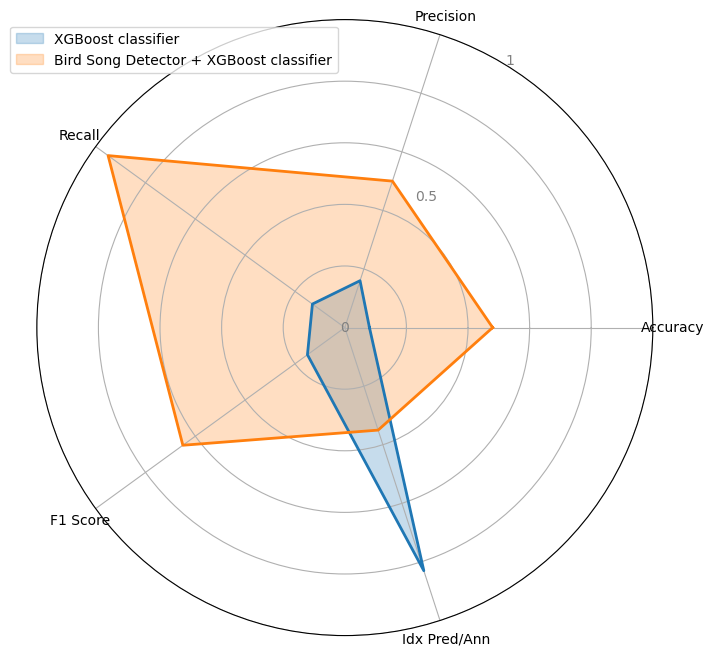

In [18]:
import numpy as np
import matplotlib.pyplot as plt

'''
XGBoost
Número de Anotaciones:  521
Number of predictions: 432
True Positive:  71
False Positive:  361
False Negative:  468
True Negative:  0
Accuracy:  0.07888888888888888
Precision:  0.16435185185185186
Recall:  0.13172541743970315
F1 Score:  0.1462409886714727
Idx Pred/Ann:  0.8291746641074856

Bird Song Detector + XGBoost
Número de Anotaciones:  521
Number of predictions:  183
True Positive:  91
False Positive:  92
False Negative:  5
True Negative:  0
Accuracy:  0.48404255319148937
Precision:  0.4972677595628415
Recall:  0.9479166666666666
F1 Score:  0.6523297491039427
Idx Pred/Ann:  0.3512476007677543
'''

# Datos de las métricas para los dos modelos
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Idx Pred/Ann']
model_1 = [0.08, 0.16, 0.13, 0.15, 0.83]
model_2 = [0.48, 0.50, 0.95, 0.65, 0.35]

# Número de variables
num_vars = len(metrics)

# Ángulos para la gráfica de radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Completar el círculo
model_1 += model_1[:1]
model_2 += model_2[:1]
angles += angles[:1]

# Inicializar la figura
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Dibujar la gráfica de radar
ax.fill(angles, model_1, color='C0', alpha=0.25, label='XGBoost classifier')
ax.fill(angles, model_2, color='C1', alpha=0.25, label='Bird Song Detector + XGBoost classifier')

# Dibujar las líneas de los modelos
ax.plot(angles, model_1, color='C0', linewidth=2, linestyle='solid')
ax.plot(angles, model_2, color='C1', linewidth=2, linestyle='solid')

# Añadir las etiquetas de las métricas
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

# Añadir la leyenda
plt.legend(loc='upper right', bbox_to_anchor=(0.5, 1))

# Add min, middle and max value to the radar chart
ax.set_ylim(0, 1)
ax.text(45, 0, '0', color='grey', ha='center', va='center')
ax.text(45, 0.5, '0.5', color='grey', ha='center', va='center')
ax.text(45, 1+0.02, '1', color='grey', ha='center', va='center')

# Título de la gráfica
# plt.title('Comparison of Model Metrics')

# Mostrar la gráfica
plt.show()

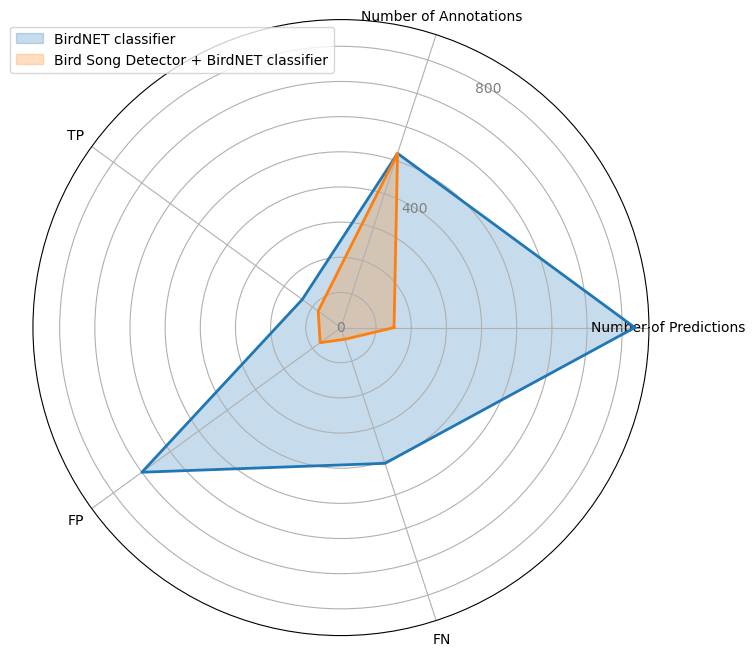

In [14]:
import numpy as np
import matplotlib.pyplot as plt

'''
BirdNET
Número de Anotaciones:  521
Number of predictions: 836
True Positive:  136
False Positive:  700
False Negative:  406
True Negative:  0
Accuracy:  0.10950080515297907
Precision:  0.16267942583732056
Recall:  0.25092250922509224
F1 Score:  0.19738751814223512
Idx Pred/Ann:  1.6046065259117082

Bird Song Detector + BirdNET
Número de Anotaciones:  521
Number of predictions:  151
True Positive:  80
False Positive:  73
False Negative:  35
True Negative:  0
Accuracy:  0.425531914893617
Precision:  0.5228758169934641
Recall:  0.6956521739130435
F1 Score:  0.5970149253731343
Idx Pred/Ann:  0.28982725527831094
'''

# Datos de las métricas para los dos modelos
metrics = ['Number of Predictions', 'Number of Annotations', 'TP', 'FP', 'FN']
model_1 = [836,521, 136, 700, 406]
model_2 = [151, 521, 80, 73, 35]

# Número de variables
num_vars = len(metrics)

# Ángulos para la gráfica de radar
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Completar el círculo
model_1 += model_1[:1]
model_2 += model_2[:1]
angles += angles[:1]

# Inicializar la figura
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Dibujar la gráfica de radar
ax.fill(angles, model_1, color='C0', alpha=0.25, label='BirdNET classifier')
ax.fill(angles, model_2, color='C1', alpha=0.25, label='Bird Song Detector + BirdNET classifier')

# Dibujar las líneas de los modelos
ax.plot(angles, model_1, color='C0', linewidth=2, linestyle='solid')
ax.plot(angles, model_2, color='C1', linewidth=2, linestyle='solid')

# Añadir las etiquetas de las métricas
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)

# Añadir la leyenda
plt.legend(loc='upper right', bbox_to_anchor=(0.5, 1))

# Add min, middle and max value to the radar chart
ax.text(45, 0, '0', color='grey', ha='center', va='center')
ax.text(45, 400, '400', color='grey', ha='center', va='center')
ax.text(45, 800, '800', color='grey', ha='center', va='center')

# Título de la gráfica
# plt.title('Comparison of Model Metrics')

# Mostrar la gráfica
plt.show()